In [1]:
import logging
from pathlib import Path
from IPython.core.display import SVG
from Pegasus.api import *

# Hierarchical Workflow

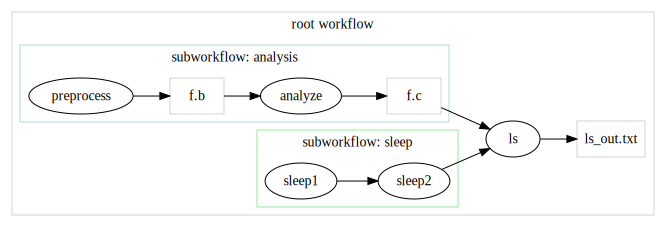

In [2]:
SVG(filename='diagram.svg')

In [ ]:
props = Properties()
####################????#######################
props["pegasus.integrity.checking"] = "none"
####################????#######################
props.write()

In [ ]:
preprocess = Transformation(
                "preprocess",
                site="condorpool",
                pfn="/home/scitech/pegasus/dist/pegasus/bin/pegasus-keg",
                is_stageable=False
            )

analyze = Transformation(
                "analyze",
                site="condorpool",
                pfn="/home/scitech/pegasus/dist/pegasus/bin/pegasus-keg",
                is_stageable=False
            )

sleep = Transformation(
                "sleep",
                site="condorpool",
                pfn="/bin/sleep",
                is_stageable=False
            )

ls = Transformation(
                "ls",
                site="condorpool",
                pfn="/bin/ls",
                is_stageable=False
            )

TransformationCatalog()\
    .add_transformations(preprocess, analyze, sleep, ls)\
    .write()

In [ ]:
Path("inputs").mkdir(exist_ok=True)

## SubWorkflow 1: Analysis

In [ ]:
analysis_wf = Workflow("analysis-wf")
fb = File("f.b")
j_preprocess = Job(preprocess, _id="preprocess")\
                .add_args("-a", "preproces", "-T", 3, "-o", fb)\
                .add_outputs(fb)

fc = File("f.c")
j_analyze = Job(analyze, _id="analyze")\
            .add_args("-a", "analyze", "-T", 5, "-i", fb, "-o", fc, "-G", 120)\
            .add_inputs(fb)\
            .add_outputs(fc, register_replica=False, stage_out=False)

analysis_wf.add_jobs(j_preprocess, j_analyze)
analysis_wf.write("inputs/analysis-wf.yml")

## SubWorkflow 2: Sleep

In [ ]:
sleep_wf = Workflow("sleep-wf")
s1 = Job(sleep, _id="sleep1").add_args(2)
s2 = Job(sleep, _id="sleep2").add_args(2)
sleep_wf.add_jobs(s1, s2)
sleep_wf.add_dependency(s1, children=[s2])
sleep_wf.write("inputs/sleep-wf.yml")

## Root Workflow

In [ ]:
h_wf = Workflow("hierarchical-wf")

analysis_wf_job = SubWorkflow("analysis-wf.yml", is_planned=False)\
                    .add_args("--input-dir", "inputs", "--output-sites", "local", "--force")\
                    .add_outputs(fc)

sleep_wf_job = SubWorkflow("sleep-wf.yml", is_planned=False)\
                .add_args("--output-sites", "local")

ls_job = Job(ls, _id="ls")\
            .add_args("-alh", fc)\
            .add_inputs(fc)\
            .set_stdout("ls_out.txt")

h_wf.add_jobs(analysis_wf_job, sleep_wf_job, ls_job)

In [ ]:
try:
    h_wf.plan(submit=True, input_dirs=["inputs"])
except PegasusClientError as e:
    print(e.output)